In [1]:
from utils.analysis_helpers import *
import re
from wtpsplit import SaT
import matplotlib.pyplot as plt

In [2]:
directory = '../Dataset/meditations_transcripts/transcripts_per_interview/csv/**/' 

df_all = load_and_combine_csv(directory)

print(f"Unique conditions before filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews before filtering: {df_all['File Name'].nunique()}")
# *0*: No "real" interview (e.g., setup phase, small talk). We filter these out.
df_all = df_all[df_all["Condition"] != 0]
print(f"Unique conditions after filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews (File Name) after filtering: {df_all['File Name'].nunique()}")

Found 82 CSV files.
Unique conditions before filtering: [1 'C' 'I' 0]
Number of interviews before filtering: 82
Unique conditions after filtering: [1 'C' 'I']
Number of interviews (File Name) after filtering: 75


In [3]:
# Group by File Name and Speaker, concatenate content
df = (
    df_all.groupby(["File Name","turn_index","Speaker","Experiment","Id","Condition"])["Content"]
    .apply(lambda x: " ".join(x))
    .reset_index(name="Full_Content")
)

# Remove single periods but keep ellipses ("...") + lowercase
df["Processed_Content"] = df["Full_Content"].apply(
    lambda x: re.sub(r"(?<!\.)\.(?!\.)", "", x).lower()
)

In [4]:
# Use trained lora modules for strong adaptation to language & domain/style
    # ted2020-corrupted : TED talks with corrupted audio (transcriptions ASR)
sat_adapted = SaT("sat-12l", style_or_domain="ted2020-corrupted", language="en")

In [5]:
# Segment text into sentences
df["Segmented_Sentences"] = df["Processed_Content"].apply(
    lambda x: list(sat_adapted.split(x))
)

# Explode the sentences into separate rows
df_exploded = df.explode("Segmented_Sentences")

# Save or inspect the result
df_exploded = df_exploded.drop(columns=["Processed_Content"])
df_exploded.rename(columns={"Segmented_Sentences": "Segmented_Sentence"}, inplace=True)

In [6]:
df_exploded = standardize_speaker_labels(df_exploded)

In [7]:
df_exploded.to_csv("./segmented_sentences.csv", index=False)

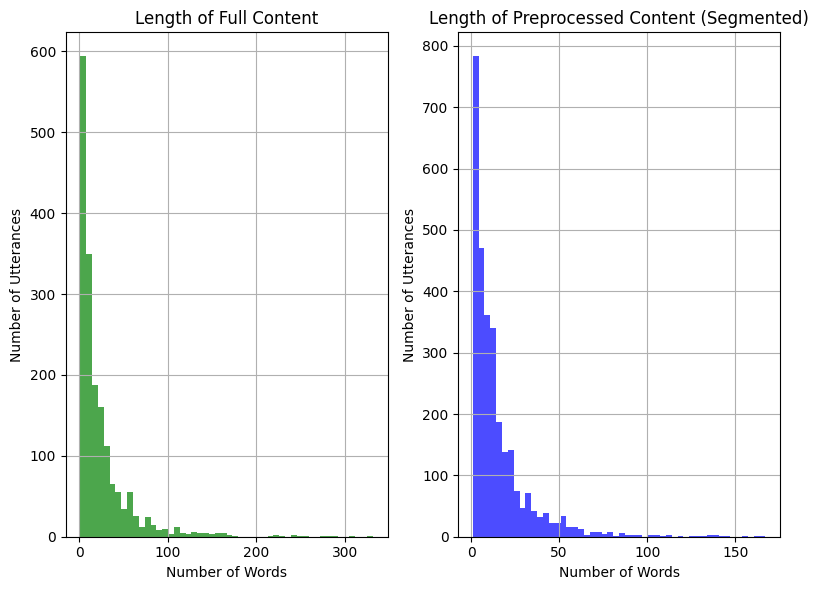

In [8]:
# Plot the histogram for the preprocessed content
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 2)
df_exploded['Segmented_Sentence'].apply(lambda x: len(x.split())).hist(bins=50, alpha=0.7, color='blue')
plt.title("Length of Preprocessed Content (Segmented)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Utterances")

# Plot the histogram for the full content
plt.subplot(1, 2, 1)
df["Full_Content"].apply(lambda x: len(x.split())).hist(bins=50, alpha=0.7, color='green')
plt.title("Length of Full Content")
plt.xlabel("Number of Words")
plt.ylabel("Number of Utterances")

plt.tight_layout()
plt.show()